In [57]:
import math
import pylab
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.svm import SVR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA


In [58]:
def get_folds(n, K):
      ### Get the appropriate number of fold labels
      n_fold = math.ceil(n / K) # Number of observations per fold (rounded up)
      fold_ids_raw = list(range(1, K+1)) * n_fold
      fold_ids = fold_ids_raw[:n]
      random.shuffle(fold_ids)
      return fold_ids

In [59]:
def rescale(x1, x2):
      for col in range(x1.shape[1]):
            a = np.min(x2[:, col])
            b = np.max(x2[:, col])
            x1[:, col] = (x1[:, col] - a) / (b - a)
      return x1

In [60]:
# Get data from csv file
cpi = pd.read_csv('data/cpi.csv') # per month from 1913-01-01 to 2022-12-01, total 1320 observations
unemployment = pd.read_csv('data/unemployment.csv') # per month from 1948-01-01 to 2022-12-01, total 900 observations
gdp = pd.read_csv('data/gdp.csv') # per quarter from 1947-01-01 to 2022-07-01, total 303 observations
fund_rate = pd.read_csv('data/fundrate.csv') # per month from 1954-07-01 to 2022-12-01, total 822 observations
retail = pd.read_csv('data/retail.csv') # per month from 1992-01-01 to 2022-12-01, total 372 observations
durables = pd.read_csv('data/durables.csv') # per month from 1992-02-01 to 2022-11-01, total 370 observations
SP500 = pd.read_csv('data/SP500.csv') # per day from 2016-01-04 to 2023-01-13, total 1771 observations


## get data

### SP500 index

In [61]:
# SP500
# Convert the 'Date' column to the 'Y-M' format
SP500['date'] = pd.to_datetime(SP500['Date']).dt.to_period('M')
# Calculate the average value for each month for column 'Close'
SP500 = SP500.groupby('date').mean()
# Subset the DataFrame with dates between 2016-01 and 2022-12
SP500 = SP500['2016-01':'2022-12']
# Only keep the column 'Close'
SP500 = SP500[['Close']]
# Rename the column 'Close' to 'SP500'
SP500.rename(columns={'Close': 'SP500'}, inplace=True)
# per month from 2016-01 to 2022-12, total 84 observations


/var/folders/xb/ck19r6wj3s34sw5xpnr7_fbm0000gp/T/ipykernel_17613/269444350.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  SP500 = SP500.groupby('date').mean()


In [62]:
SP500_MA7 = SP500.rolling(window=7).mean()
SP500_MA15 = SP500.rolling(window=7).mean()
SP500_MA7

,SP500
date,
2016-01,NaN
2016-02,NaN
2016-03,NaN
2016-04,NaN
2016-05,NaN
...,...
2022-08,4175.448717
2022-09,4091.811574
2022-10,3996.780959


### CPI

In [63]:
# CPI
# Drop the first column 'Unnamed: 0'
cpi = cpi.drop(columns=['Unnamed: 0'])
# Convert the 'date' column to the 'Y-M' format
cpi['date'] = pd.to_datetime(cpi['date']).dt.to_period('M')
# Subset the DataFrame with dates between 2016-01 and 2022-12
cpi.set_index('date', inplace=True)
cpi = cpi['2022-12':'2016-01']
cpi = cpi.sort_index(ascending=True)
# Rename the column 'value' to 'CPI'
cpi.rename(columns={'value': 'CPI'}, inplace=True)
# per month from 2016-01 to 2022-12, total 84 observations

### unemployment

In [64]:
# unemployment
# Drop the first column 'Unnamed: 0'
unemployment = unemployment.drop(columns=['Unnamed: 0'])
# Convert the 'date' column to the 'Y-M' format
unemployment['date'] = pd.to_datetime(unemployment['date']).dt.to_period('M')
# Subset the DataFrame with dates between 2016-01 and 2022-12
unemployment.set_index('date', inplace=True)
unemployment = unemployment['2022-12':'2016-01']
unemployment = unemployment.sort_index(ascending=True)
# Rename the column 'value' to 'Unemployment'
unemployment.rename(columns={'value': 'Unemployment'}, inplace=True)
# per month from 2016-01 to 2022-12, total 84 observations

### gdp

In [65]:
# gdp
# Drop the first column 'Unnamed: 0'
gdp = gdp.drop(columns=['Unnamed: 0'])
# Convert the 'date' column to the 'Y-M' format
gdp['date'] = pd.to_datetime(gdp['date']).dt.to_period('M')
# Subset the DataFrame with dates between 2016-01 and 2022-07
gdp.set_index('date', inplace=True)
gdp = gdp['2022-07':'2016-01']
gdp = gdp.sort_index(ascending=True)
# Rename the column 'value' to 'GDP'
gdp.rename(columns={'value': 'GDP'}, inplace=True)
# per quarter from 2016-01 to 2022-07, total 27 observations

### fund_rate

In [66]:
# fund_rate
# Drop the first column 'Unnamed: 0'
fund_rate = fund_rate.drop(columns=['Unnamed: 0'])
# Convert the 'date' column to the 'Y-M' format
fund_rate['date'] = pd.to_datetime(fund_rate['date']).dt.to_period('M')
# Subset the DataFrame with dates between 2016-01 and 2022-12
fund_rate.set_index('date', inplace=True)
fund_rate = fund_rate['2022-12':'2016-01']
fund_rate = fund_rate.sort_index(ascending=True)
# Rename the column 'value' to 'Fund_rate'
fund_rate.rename(columns={'value': 'Fund_rate'}, inplace=True)
# per month from 2016-01 to 2022-12, total 84 observations

### retail

In [67]:
# retail
# Drop the first column 'Unnamed: 0'
retail = retail.drop(columns=['Unnamed: 0'])
# Convert the 'date' column to the 'Y-M' format
retail['date'] = pd.to_datetime(retail['date']).dt.to_period('M')
# Subset the DataFrame with dates between 2016-01 and 2022-12
retail.set_index('date', inplace=True)
retail = retail['2022-12':'2016-01']
retail = retail.sort_index(ascending=True)
# Rename the column 'value' to 'Retail'
retail.rename(columns={'value': 'Retail'}, inplace=True)
# per month from 2016-01 to 2022-12, total 84 observations

### durables

In [68]:
# durables
# Drop the first column 'Unnamed: 0'
durables = durables.drop(columns=['Unnamed: 0'])
# Convert the 'date' column to the 'Y-M' format
durables['date'] = pd.to_datetime(durables['date']).dt.to_period('M')
# Subset the DataFrame with dates between 2016-01 and 2022-07
durables.set_index('date', inplace=True)
durables = durables['2022-07':'2016-01']
durables = durables.sort_index(ascending=True)
# Rename the column 'value' to 'Durables'
durables.rename(columns={'value': 'Durables'}, inplace=True)
# per month from 2016-01 to 2022-07, total 79 observations

### merge all df

In [76]:
# Merge all dataframes (exclude GDP for now)
df = pd.concat([SP500, cpi, unemployment, fund_rate, retail], axis=1)
df7 = pd.concat([SP500_MA7, cpi, unemployment, fund_rate, retail], axis=1)[6:]
df15 = pd.concat([SP500_MA15, cpi, unemployment, fund_rate, retail], axis=1)[14:]


## analysis

In [ ]:
df.head()

In [ ]:
########## Analysis of the data ##########
# Correlation matrix
df.corr()
#%%

# # Scatter plot
# for i in range(len(df.columns)):
#       for j in range(i+1, len(df.columns)):
#             col1 = df.columns[i]
#             col2 = df.columns[j]
#             sns.scatterplot(x=col1, y=col2, data=df)
#             plt.title(col1 + ' vs ' + col2)
#             plt.show()

In [ ]:
# pair = sns.load_dataset(df)
# sns.pairplot(df)

In [ ]:
# Time series plot
for column in df7.columns:
      df7[column].plot()
      plt.title(column)
      plt.show()

## model

### Processing

In [77]:
########## Data preprocessing ##########

#### Fit time series cross-validation models
# X = df.drop(columns='SP500')
# Y = df['SP500']
# tscv = TimeSeriesSplit(n_splits=10)
# This allows you to split the data into training and test sets by specifying the number of splits,
# and it ensures that the splits are done in a time-sensitive manner so that the training sets are
# always before the test sets in time.
def data_split(df):
      X = df.drop(columns='SP500')
      Y = df['SP500']
      tscv = TimeSeriesSplit(n_splits=10)
      return X, Y, tscv
X,Y, tscv = data_split(df)
X7,Y7, tscv7 = data_split(df7)
X15,Y15, tscv15 = data_split(df15)


In [90]:
def model_train(X, Y, tscv):
      for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            # Linear regression
            lm = sm.OLS(Y_train, X_train).fit()
            lm_mse = mean_squared_error(Y_test, lm.predict(X_test))
            # print('Linear regression MSE: ', lm_mse)

            # Decision tree
            Tree = DecisionTreeRegressor().fit(X_train, Y_train)
            Tree_mse = mean_squared_error(Y_test, Tree.predict(X_test))
            # print('Decision tree MSE: ', Tree_mse)

            # Random forest
            RF = RandomForestRegressor().fit(X_train, Y_train)
            RF_mse = mean_squared_error(Y_test, RF.predict(X_test))
            # print('Random forest MSE: ', RF_mse)

            # Gradient boosting
            GB = GradientBoostingRegressor().fit(X_train, Y_train)
            GB_mse = mean_squared_error(Y_test, GB.predict(X_test))
            # print('Gradient boosting MSE: ', GB_mse)

            # KNN
            KNN = KNeighborsRegressor().fit(X_train, Y_train)
            KNN_mse = mean_squared_error(Y_test, KNN.predict(X_test))
            # print('KNN MSE: ', KNN_mse)
            MSE = pd.DataFrame({'MSE': [lm_mse, Tree_mse, RF_mse, GB_mse, KNN_mse]},
                        index=['Linear Regression', 'Decision Tree', 'Random Forest',
                              'Gradient Boosting', 'KNN'])
            print(MSE)
            print('--------------------------------------')
            return X_train, X_test, Y_train, Y_test, lm, Tree, RF, GB, KNN
      
X_train, X_test, Y_train, Y_test, lm, Tree, RF, GB, KNN = model_train(X, Y, tscv)
X_train7, X_test7, Y_train7, Y_test7, lm7, Tree7, RF7, GB7, KNN7 = model_train(X7, Y7, tscv7)


                            MSE
Linear Regression  65351.137571
Decision Tree      10752.140005
Random Forest      21677.131973
Gradient Boosting  15306.959323
KNN                91071.604468
--------------------------------------
                            MSE
Linear Regression    773.353312
Decision Tree      19019.147052
Random Forest      27639.899785
Gradient Boosting  25257.851560
KNN                63643.916758
--------------------------------------


In [95]:
Y.tail()

date
2022-08    4158.563084
2022-09    3850.520496
2022-10    3726.050956
2022-11    3917.488595
2022-12    3912.380952
Freq: M, Name: SP500, dtype: float64

In [94]:
Y7.tail()

date
2022-08    4175.448717
2022-09    4091.811574
2022-10    3996.780959
2022-11    3929.094187
2022-12    3910.811466
Freq: M, Name: SP500, dtype: float64

In [ ]:
#### Make a table of MSE
# MSE = pd.DataFrame({'MSE': [lm_mse, Tree_mse, RF_mse, GB_mse, KNN_mse]},
#                         index=['Linear Regression', 'Decision Tree', 'Random Forest',
#                               'Gradient Boosting', 'KNN'])
# MSE

In [ ]:
# #### Make a MSE plot
# MSE.plot(kind='bar')
# plt.title('MSE of different models')
# plt.show()

# #%%
# ### Make a relative MSE plot
# MSE['Relative MSE'] = MSE['MSE'] / MSE['MSE'].min()
# MSE.plot(kind='bar', y='Relative MSE')
# plt.title('Relative MSE of different models')
# plt.show()

In [ ]:
# fit Auto ARIMA model, order is automatically selected
auto_arima_model = auto_arima(SP500_train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
# Print model summary
print(auto_arima_model.summary())

In [ ]:
Y_test.index

In [ ]:
Y_test2 = Y_test.reset_index()
Y_test2.head(2)

In [ ]:
Y_test2['date'] = pd.to_datetime(Y_test2['date'].astype(str))
Y_test2.head(2)

In [ ]:
y_pred = lm.predict(X_test)
y_pred.values

In [88]:
Y_test2.tail(1)

,date,SP500
6,2017-09-01,2492.84104


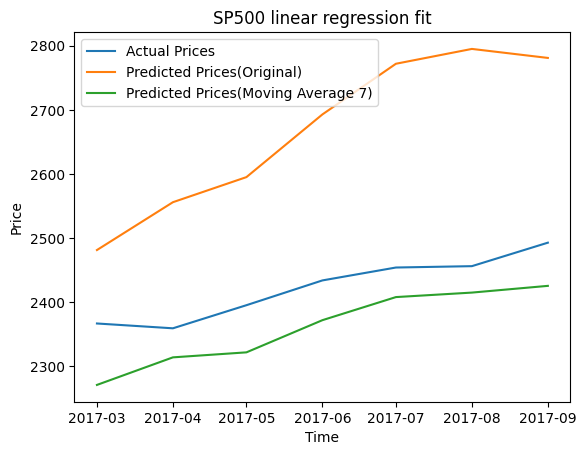

In [93]:
Y_test2 = Y_test.reset_index()
Y_test2['date'] = pd.to_datetime(Y_test2['date'].astype(str))
y_pred = lm.predict(X_test)

Y_test2_7 = Y_test7.reset_index()
Y_test2_7['date'] = pd.to_datetime(Y_test2_7['date'].astype(str))
y_pred_7 = lm7.predict(X_test7)
plt.plot(Y_test2['date'], Y_test2['SP500'], label='Actual Prices')
plt.plot(Y_test2['date'], y_pred.values, label='Predicted Prices(Original)')
plt.plot(Y_test2_7['date'], y_pred_7.values, label='Predicted Prices(Moving Average 7)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('SP500 linear regression fit')
plt.legend()
plt.show()

In [104]:
X_train.tail()

,CPI,Unemployment,Fund_rate,Retail
date,,,,
2016-10,241.729,4.9,0.40,397394
2016-11,241.353,4.7,0.41,413901
2016-12,241.432,4.7,0.54,482002
2017-01,242.839,4.7,0.65,369081
2017-02,243.603,4.6,0.66,365592


In [103]:
Y_test2.tail()

,date,SP500
2,2017-05-01,2395.345881
3,2017-06-01,2433.985451
4,2017-07-01,2454.102502
5,2017-08-01,2456.223070
6,2017-09-01,2492.841040
